<a href="https://colab.research.google.com/github/mineramc/GTSRB_image_recognition/blob/master/GTSRB_RandomForestClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pulling Data from Kaggle 
Upload kaggle.json into folder before running this code

In [1]:
! pip install kaggle;

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

 97% 596M/612M [00:02<00:00, 196MB/s]
100% 612M/612M [00:03<00:00, 209MB/s]


In [6]:
! mkdir data

In [7]:
! unzip gtsrb-german-traffic-sign.zip -d data > /dev/null 2>&1



```
# This is formatted as code
```

# Pulling ZIP file from Drive

In [1]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


# Image pre-processing

In [8]:
# get list of all image files from .csv files
# for each image, import as PIL image, grayscale it, and then save as another png/store as numPy array
# 

# Random Forest Classifier

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
import cv2
import os
from PIL import Image, ImageOps
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
# Constants utilized throughout the notebook
DATA_DIR = "/content/data"
NUM_CLASSES = 43
IMG_HEIGHT = 30
IMG_WIDTH = 30

train_labels = []
train_data = []
greyscale_train_data = []


# Import all training images and resize/grayscale them
for classID in range(0, NUM_CLASSES):
  image_folder = os.path.join(DATA_DIR, 'Train', str(classID))
  for _ , _, files in os.walk(image_folder):
    for img_file in files:
      img_path = os.path.join(image_folder, img_file)
      try:
        img_arr = cv2.imread(img_path)
        img = Image.fromarray(img_arr, 'RGB')
        resize_image = img.resize((IMG_HEIGHT, IMG_WIDTH))
        greyscale_image = ImageOps.grayscale(resize_image)
        train_labels.append(classID)
        train_data.append(np.array(resize_image))
        greyscale_train_data.append(np.array(greyscale_image))
      except:
        print("Error with importing image.")

train_data = np.array(train_data)
train_labels = np.array(train_labels)
greyscale_train_data = np.array(greyscale_train_data)

print("Training Data Shape:", train_data.shape)
print("Training Label Shape:", train_labels.shape)
print("Greyscale Training Data Shape:", greyscale_train_data.shape)

Training Data Shape: (39209, 30, 30, 3)
Training Label Shape: (39209,)
Greyscale Training Data Shape: (39209, 30, 30)


In [11]:
# Shuffles the indices and then reorders all both data arrays 
# and the label array based on the new indices

indices = np.arange(0, np.shape(train_labels)[0])
rng = np.random.default_rng()
rng.shuffle(indices)
train_data = train_data[indices]
train_labels = train_labels[indices]
greyscale_train_data = greyscale_train_data[indices]

In [12]:

test_csv = os.path.join(DATA_DIR, "Test.csv")
test_df = pd.read_csv(test_csv)
test_df.head()
test_labels = np.array(test_df['ClassId'])
test_paths = test_df['Path']



greyscale_test_data = []
test_data = []

for _, path in test_paths.items():
  img_path = os.path.join(DATA_DIR, path)
  try:
    img_arr = cv2.imread(img_path)
    img = Image.fromarray(img_arr, 'RGB')
    resize_image = img.resize((IMG_HEIGHT, IMG_WIDTH))
    greyscale_image = ImageOps.grayscale(resize_image)
    test_data.append(np.array(resize_image))
    greyscale_test_data.append(np.array(greyscale_image))
  except:
    print("Error with importing image.")

test_data = np.array(test_data)
greyscale_test_data = np.array(greyscale_test_data)

print("Testing Data Shape:", test_data.shape)
print("Testing Label Shape:", test_labels.shape)
print("Greyscale Testing Data Shape:", greyscale_test_data.shape)

Testing Data Shape: (12630, 30, 30, 3)
Testing Label Shape: (12630,)
Greyscale Testing Data Shape: (12630, 30, 30)


Variables:  

*   train_data: NumPy array of ~39000 RGB training images
*   greyscale_train_data: NumPy array of ~39000 greyscale training images
*   train_labels: NumPy array of ClassIDs for the training dataset
*   test_data: NumPy array of ~12000 RGB testing images
*   greyscale_test_data: NumPy array of ~12000 greyscale testing images
*   test_labels: NumPy array of ClassIDs for the testing dataset



In [13]:
# Normalize all the pixel values for the training data to be between 0 and 1

X_train = train_data
X_train = X_train / 255
Y_train = train_labels
X_train_greyscale = greyscale_train_data
X_train_greyscale = X_train_greyscale / 255

X_test = test_data
X_test = X_test / 255
Y_test = test_labels
X_test_greyscale = greyscale_test_data
X_test_greyscale = X_test_greyscale / 255

In [14]:
# sklearn expects i/p to be 2d array-model.fit(x_train,y_train)=>reshape to 2d array
nsamples, nx, ny, nrgb = X_train.shape
X_train2 = X_train.reshape((nsamples, nx*ny*nrgb))

nsamples, nx, ny = X_train_greyscale.shape
X_train_greyscale2 = X_train_greyscale.reshape((nsamples, nx*ny))

# so,eventually,model.predict() should also be a 2d input
nsamples, nx, ny, nrgb = X_test.shape
X_test2 =  X_test.reshape((nsamples,nx*ny*nrgb))

nsamples, nx, ny = X_test_greyscale.shape
X_test_greyscale2 = X_test_greyscale.reshape((nsamples, nx*ny))

In [15]:
rf = RandomForestClassifier()
rf_fit = rf.fit(X_train2, Y_train)
Y_pred_rf = rf_fit.predict(X_test2)
Y_pred_rf

print(accuracy_score(Y_pred_rf, Y_test))

0.7802058590657166


In [16]:
rf_greyscale = RandomForestClassifier()
rf_fit_greyscale = rf_greyscale.fit(X_train_greyscale2, Y_train)
Y_pred_rf_greyscale = rf_fit_greyscale.predict(X_test_greyscale2)
Y_pred_rf_greyscale

print(accuracy_score(Y_pred_rf_greyscale, Y_test))

0.7643705463182898


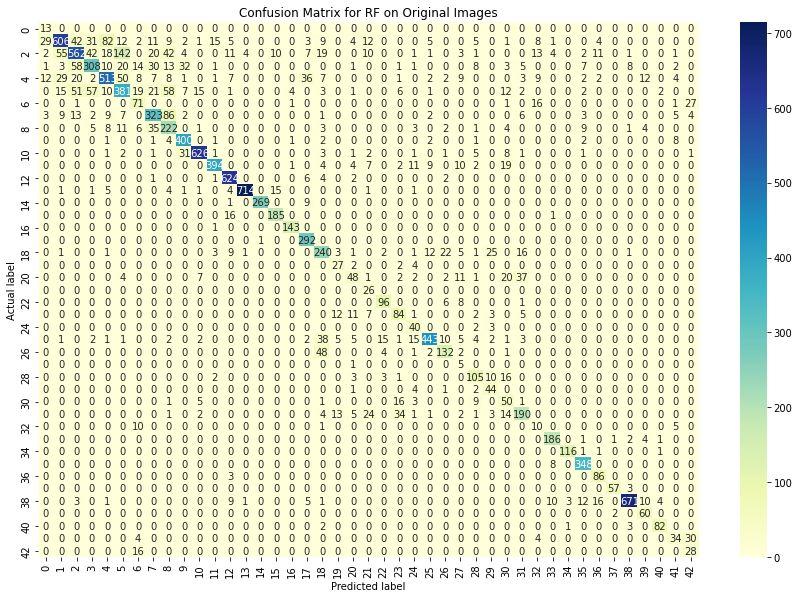

In [17]:
conf_mat_rf = confusion_matrix(Y_pred_rf, Y_test)
classes = [0, 1]
plt.figure(figsize=(12,8))
tick_marks = np.arange(len(classes))

plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

sns.heatmap(pd.DataFrame(conf_mat_rf), annot=True,cmap='YlGnBu',fmt='g')
plt.tight_layout()
plt.title('Confusion Matrix for RF on Original Images', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.savefig('conf_mat_rf.png')

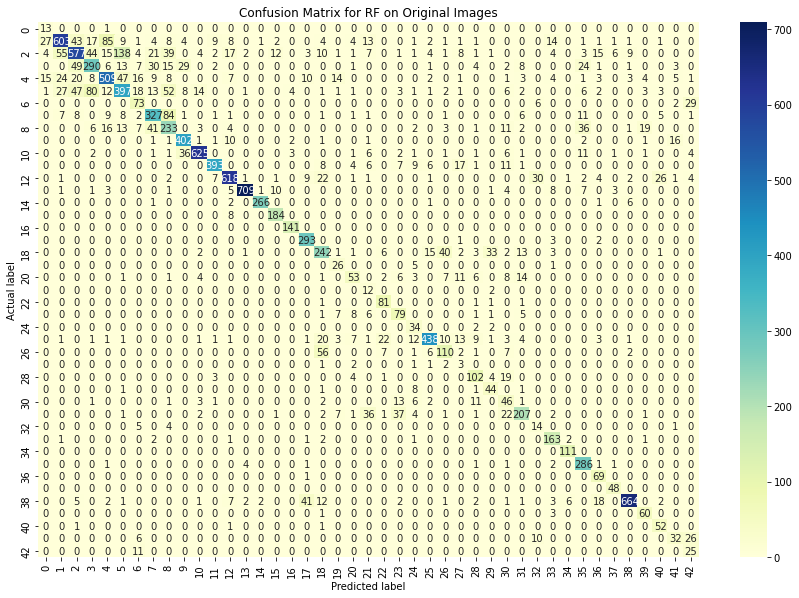

In [18]:
conf_mat_rf_greyscale = confusion_matrix(Y_pred_rf_greyscale, Y_test)
classes = [0, 1]
plt.figure(figsize=(12,8))
tick_marks = np.arange(len(classes))

plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

sns.heatmap(pd.DataFrame(conf_mat_rf_greyscale), annot=True,cmap='YlGnBu',fmt='g')
plt.tight_layout()
plt.title('Confusion Matrix for RF on Greyscale Images', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.savefig('conf_mat_rf_greyscale.png')

In [30]:
# Cropping images

train_csv = os.path.join(DATA_DIR, "Train.csv")
train_df = pd.read_csv(train_csv)
train_df.head()

greyscale_crop_train_data = []
crop_train_data = []
train_labels = np.array(train_df['ClassId'])

for _, row in train_df.iterrows():
  img_path = os.path.join(DATA_DIR, row['Path'])
  try:
    img_arr = cv2.imread(img_path)
    img = Image.fromarray(img_arr, 'RGB')

    # Crop images based on Roi.X, Roi.Y
    # PIL's Image.crop() expects it in (left, upper, right, lower)
    # Roi.X1 / Y1 are upper left, Roi.X2 / Y2 are lower right
    cropped_img = img.crop((row['Roi.X1'], row['Roi.Y1'], row['Roi.X2'], row['Roi.Y2']))
    resize_image = cropped_img.resize((IMG_HEIGHT, IMG_WIDTH))
    greyscale_image = ImageOps.grayscale(resize_image)
    crop_train_data.append(np.array(resize_image))
    greyscale_crop_train_data.append(np.array(greyscale_image))
  except:
    print("Error with importing image.")

crop_train_data = np.array(crop_train_data)
greyscale_crop_train_data = np.array(greyscale_crop_train_data)

print("Testing Data Shape:", crop_train_data.shape)
print("Testing Label Shape:", test_labels.shape)
print("Greyscale Testing Data Shape:", greyscale_crop_train_data.shape)

Testing Data Shape: (39209, 30, 30, 3)
Testing Label Shape: (39209,)
Greyscale Testing Data Shape: (39209, 30, 30)


In [31]:
# Cropping test images
greyscale_crop_test_data = []
crop_test_data = []
test_labels = np.array(test_df['ClassId'])

for _, row in test_df.iterrows():
  img_path = os.path.join(DATA_DIR, row['Path'])
  try:
    img_arr = cv2.imread(img_path)
    img = Image.fromarray(img_arr, 'RGB')

    # Crop images based on Roi.X, Roi.Y
    # PIL's Image.crop() expects it in (left, upper, right, lower)
    # Roi.X1 / Y1 are upper left, Roi.X2 / Y2 are lower right
    cropped_img = img.crop((row['Roi.X1'], row['Roi.Y1'], row['Roi.X2'], row['Roi.Y2']))
    resize_image = cropped_img.resize((IMG_HEIGHT, IMG_WIDTH))
    greyscale_image = ImageOps.grayscale(resize_image)
    crop_test_data.append(np.array(resize_image))
    greyscale_crop_test_data.append(np.array(greyscale_image))
  except:
    print("Error with importing image.")

crop_test_data = np.array(crop_test_data)
greyscale_crop_test_data = np.array(greyscale_crop_test_data)

print("Testing Data Shape:", crop_test_data.shape)
print("Testing Label Shape:", test_labels.shape)
print("Greyscale Testing Data Shape:", greyscale_crop_test_data.shape)

Testing Data Shape: (12630, 30, 30, 3)
Testing Label Shape: (12630,)
Greyscale Testing Data Shape: (12630, 30, 30)


In [32]:
# Normalize all the pixel values for the training data to be between 0 and 1

X_train = crop_train_data
X_train = X_train / 255
Y_train = train_labels
X_train_greyscale = greyscale_crop_train_data
X_train_greyscale = X_train_greyscale / 255

X_test = crop_test_data
X_test = X_test / 255
Y_test = test_labels
X_test_greyscale = greyscale_crop_test_data
X_test_greyscale = X_test_greyscale / 255

In [33]:
# sklearn expects i/p to be 2d array-model.fit(x_train,y_train)=>reshape to 2d array
nsamples, nx, ny, nrgb = X_train.shape
X_train2 = X_train.reshape((nsamples, nx*ny*nrgb))

nsamples, nx, ny = X_train_greyscale.shape
X_train_greyscale2 = X_train_greyscale.reshape((nsamples, nx*ny))

# so,eventually,model.predict() should also be a 2d input
nsamples, nx, ny, nrgb = X_test.shape
X_test2 =  X_test.reshape((nsamples,nx*ny*nrgb))

nsamples, nx, ny = X_test_greyscale.shape
X_test_greyscale2 = X_test_greyscale.reshape((nsamples, nx*ny))

In [34]:
rf_cropped = RandomForestClassifier()
rf_fit_cropped = rf_cropped.fit(X_train2, Y_train) # 3 min no gpu boost
Y_pred_rf_cropped = rf_fit_cropped.predict(X_test2)
Y_pred_rf_cropped

print(accuracy_score(Y_pred_rf_cropped, Y_test))

0.8178147268408551


In [35]:
rf_greyscale_cropped = RandomForestClassifier()
rf_fit_greyscale_cropped = rf_greyscale_cropped.fit(X_train_greyscale2, Y_train) # 1 min no gpu boost
Y_pred_rf_greyscale_cropped = rf_fit_greyscale_cropped.predict(X_test_greyscale2)
Y_pred_rf_greyscale_cropped

print(accuracy_score(Y_pred_rf_greyscale_cropped, Y_test))

0.8068091844813935


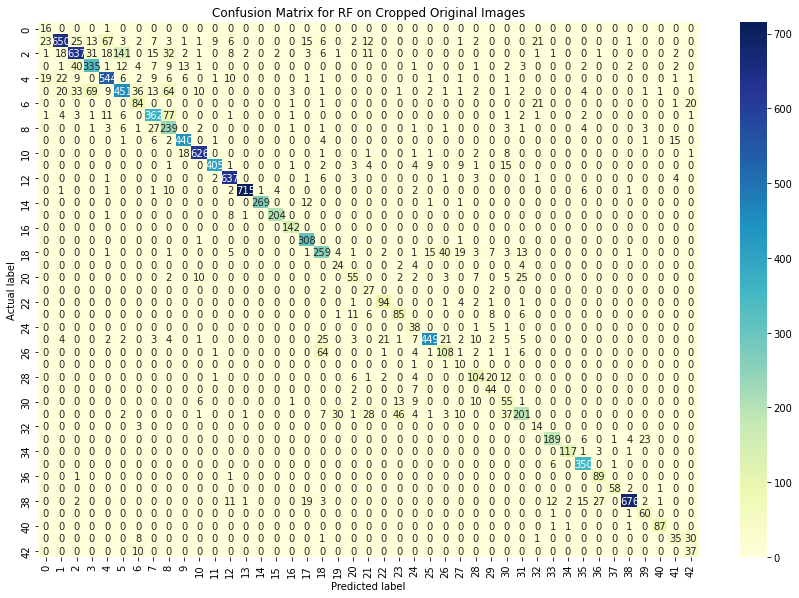

In [36]:
conf_mat_rf = confusion_matrix(Y_pred_rf_cropped, Y_test)
classes = [0, 1]
plt.figure(figsize=(12,8))
tick_marks = np.arange(len(classes))

plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

sns.heatmap(pd.DataFrame(conf_mat_rf), annot=True,cmap='YlGnBu',fmt='g')
plt.tight_layout()
plt.title('Confusion Matrix for RF on Cropped Original Images', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.savefig('conf_mat_rf_cropped.png')

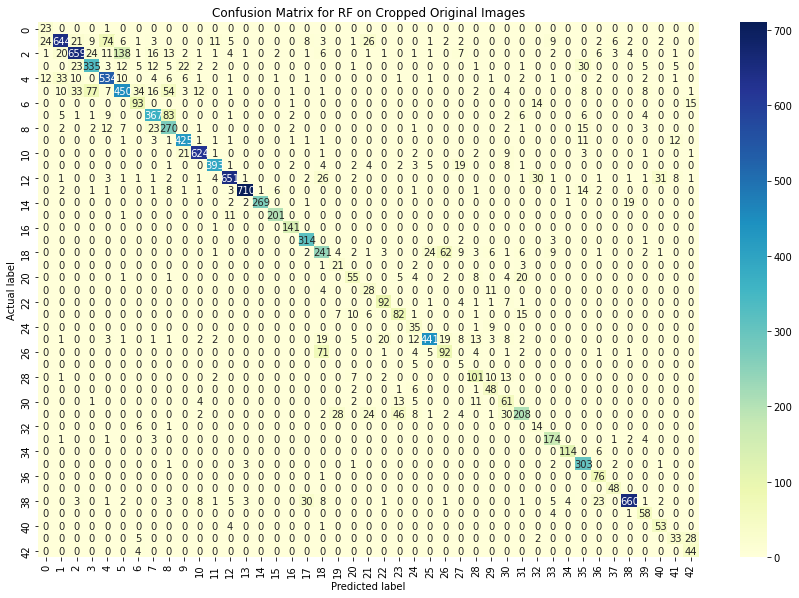

In [37]:
conf_mat_rf = confusion_matrix(Y_pred_rf_greyscale_cropped, Y_test)
classes = [0, 1]
plt.figure(figsize=(12,8))
tick_marks = np.arange(len(classes))

plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

sns.heatmap(pd.DataFrame(conf_mat_rf), annot=True,cmap='YlGnBu',fmt='g')
plt.tight_layout()
plt.title('Confusion Matrix for RF on Cropped Original Images', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.savefig('conf_mat_rf_greyscale_cropped.png')